In [113]:
# ====================================
# 1. Import Libraries and Setup
# ====================================
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


In [114]:

np.random.seed(42)

# ====================================
# 2. Data Loading
# ====================================
def load_pickle_data(file_path):
    """
    Attempt to load a DataFrame from a pickle file.
    
    Args:
        file_path (str): The path to the pickle file.
        
    Returns:
        data (DataFrame): The loaded pandas DataFrame or None if file is not found.
    """
    try:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        print(f"Data successfully loaded from: {file_path}")
        return data
    except FileNotFoundError:
        print(f"File '{file_path}' not found. Check the file path and try again.")
        return None

In [115]:


# File path provided by the user
file_path = "NetGEX_AbsGEX_EPS(MSFT).pickle"
data = load_pickle_data(file_path)

if data is not None:
    print("Columns in the loaded data:")
    print(data.columns.tolist())


Data successfully loaded from: NetGEX_AbsGEX_EPS(MSFT).pickle
Columns in the loaded data:
['Spot_Open', 'Spot_Close', 'Spot_High', 'Spot_Low', 'PCT_EPS_1mo_Open', 'PCT_EPS_1mo_Close', 'PCT_EPS_1mo_High', 'PCT_EPS_1mo_Low', 'open_abs_gex', 'high_abs_gex', 'low_abs_gex', 'close_abs_gex', 'volume_abs_gex', 'open_net_gex', 'high_net_gex', 'low_net_gex', 'close_net_gex', 'volume_net_gex']


C:\Users\Admin\AppData\Local\Temp\ipykernel_23232\1176801963.py:18: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)


In [116]:
data['date'] = pd.to_datetime(data.index)
data.sort_values('date', inplace=True)

In [117]:

# --- Feature: Daily Return ---
# Calculate daily return using Spot_Close.
data['daily_return'] = data['Spot_Close'].pct_change().fillna(0)

# --- Target Variable ---
# Binary target: 1 if next day's Spot_Close is higher, else 0.
data['target'] = (data['Spot_Close'].shift(-1) > data['Spot_Close']).astype(int)
data = data.iloc[:-1]  # Drop last row due to shift

# --- Feature Scaling ---
scaler = MinMaxScaler()
data['Spot_Close_scaled'] = scaler.fit_transform(data[['Spot_Close']])
data['daily_return_scaled'] = scaler.fit_transform(data[['daily_return']])

print("\nData after preprocessing and feature engineering:")


Data after preprocessing and feature engineering:


In [118]:

# --- Step 2: Basic Cleanup ---
df = data.copy()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Clip outliers in GEX-related columns to reduce noise
gex_columns = [col for col in df.columns if 'gex' in col.lower()]
df[gex_columns] = df[gex_columns].clip(lower=df[gex_columns].quantile(0.01),
                                       upper=df[gex_columns].quantile(0.99), axis=1)


C:\Users\Admin\AppData\Local\Temp\ipykernel_23232\3592349862.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_23232\3592349862.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [119]:

# --- Step 3: Feature Engineering ---

# Add return features
df['spot_return'] = df['Spot_Close'].pct_change().fillna(0)
df['spot_rolling_mean'] = df['Spot_Close'].rolling(window=5).mean().fillna(method='bfill')
df['spot_rolling_std'] = df['Spot_Close'].rolling(window=5).std().fillna(method='bfill')

# Add target label: Buy (1), Sell (-1), Hold (0)
threshold = 0.001  # 0.1% movement
df['future_return'] = df['Spot_Close'].pct_change(periods=5).shift(-5)
df['target'] = 0
df.loc[df['future_return'] > threshold, 'target'] = 1
df.loc[df['future_return'] < -threshold, 'target'] = -1
df.dropna(subset=['target'], inplace=True)

# --- Step 4: Prepare features and labels ---
feature_cols = [col for col in df.columns if col not in ['future_return', 'target']]
X = df[feature_cols]
y = df['target']

C:\Users\Admin\AppData\Local\Temp\ipykernel_23232\2774169941.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['spot_rolling_mean'] = df['Spot_Close'].rolling(window=5).mean().fillna(method='bfill')
C:\Users\Admin\AppData\Local\Temp\ipykernel_23232\2774169941.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['spot_rolling_std'] = df['Spot_Close'].rolling(window=5).std().fillna(method='bfill')


In [120]:

# Fill any remaining NaNs (e.g., from rolling windows)
X.fillna(X.median(), inplace=True)


C:\Users\Admin\AppData\Local\Temp\ipykernel_23232\2847396058.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.median(), inplace=True)


In [121]:
if 'timestamp' in X.columns:
    X = X.drop(columns=['timestamp'])

# Alternatively, drop any non-numeric columns
X = X.select_dtypes(include=[np.number])

In [122]:
# --- Final Cleanups Before Model ---
# Remove any accidentally included datetime columns
X = X.select_dtypes(include=[np.number])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [128]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier(class_weight='balanced', random_state=42)

scores = cross_val_score(model, X, y, cv=skf, scoring='f1_macro')
print("F1 Macro Score (5-Fold CV):", scores.mean())


F1 Macro Score (5-Fold CV): 0.4623922808143752


In [129]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(model, X, y, cv=skf)

# Print the full classification report
print("Classification Report (5-Fold CV):")
print(classification_report(y, y_pred))

Classification Report (5-Fold CV):
              precision    recall  f1-score   support

          -1       0.58      0.19      0.29     24855
           0       0.74      0.95      0.83    115459
           1       0.57      0.18      0.27     25393

    accuracy                           0.72    165707
   macro avg       0.63      0.44      0.46    165707
weighted avg       0.69      0.72      0.66    165707



In [130]:
model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [125]:
df_test = X_test.copy()

In [126]:
df_test["predicted_signal"] = y_pred

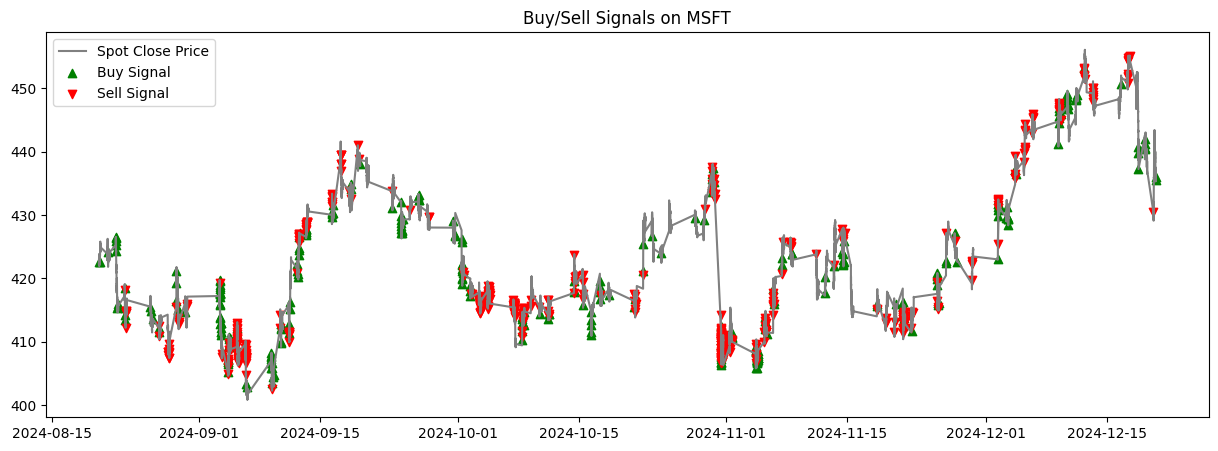

In [127]:
plt.figure(figsize=(15, 5))
plt.plot(df_test.index, df_test['Spot_Close'], label='Spot Close Price', color='gray')

buy_signals = df_test[df_test['predicted_signal'] == 1]
sell_signals = df_test[df_test['predicted_signal'] == -1]

plt.scatter(buy_signals.index, buy_signals['Spot_Close'], label='Buy Signal', marker='^', color='green')
plt.scatter(sell_signals.index, sell_signals['Spot_Close'], label='Sell Signal', marker='v', color='red')

plt.title("Buy/Sell Signals on MSFT")
plt.legend()

In [133]:
import joblib
joblib.dump(model, r'models/stock_predictor_MSFT.pkl')

['models/stock_predictor_MSFT.pkl']